In [60]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [61]:
def parse_log_line(line):
  regex = r'(?P<ip>\d+\.\d+\.\d+\.\d+) - - \[(?P<timestamp>.*?)\] "(?P<request>.*?)" (?P<status>\d+) (?P<bytes_sent>\d+) "(?P<referrer>.*?)" "(?P<user_agent>.*?)"'
  match = re.match(regex, line)
  return match.groupdict() if match else None

rows = []
with open('access.log', 'r') as file:
  for line in file:
    row = parse_log_line(line)
    if row:
      rows.append(row)

df = pd.DataFrame(rows)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')
df['status'] = pd.to_numeric(df['status'], errors='coerce')
df['bytes_sent'] = pd.to_numeric(df['bytes_sent'], errors='coerce')
df['date'] = df['timestamp'].dt.date
df['endpoint'] = df['request'].apply(lambda x: x.split()[1])

df.head()

,ip,timestamp,request,status,bytes_sent,referrer,user_agent,date,endpoint
0,83.149.9.216,2015-05-17 10:05:03+00:00,GET /presentations/logstash-monitorama-2013/im...,200,203023,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,2015-05-17,/presentations/logstash-monitorama-2013/images...
1,83.149.9.216,2015-05-17 10:05:43+00:00,GET /presentations/logstash-monitorama-2013/im...,200,171717,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,2015-05-17,/presentations/logstash-monitorama-2013/images...
2,83.149.9.216,2015-05-17 10:05:47+00:00,GET /presentations/logstash-monitorama-2013/pl...,200,26185,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,2015-05-17,/presentations/logstash-monitorama-2013/plugin...
3,83.149.9.216,2015-05-17 10:05:12+00:00,GET /presentations/logstash-monitorama-2013/pl...,200,7697,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,2015-05-17,/presentations/logstash-monitorama-2013/plugin...
4,83.149.9.216,2015-05-17 10:05:07+00:00,GET /presentations/logstash-monitorama-2013/pl...,200,2892,http://semicomplete.com/presentations/logstash...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,2015-05-17,/presentations/logstash-monitorama-2013/plugin...


In [62]:
df.groupby('date').size()

date
2015-05-17    1575
2015-05-18    2570
2015-05-19    2702
2015-05-20    2483
dtype: int64

In [63]:
df.groupby('date')['ip'].nunique()

date
2015-05-17    325
2015-05-18    584
2015-05-19    526
2015-05-20    478
Name: ip, dtype: int64

In [64]:
df.groupby('date')['user_agent'].nunique()

date
2015-05-17    165
2015-05-18    250
2015-05-19    244
2015-05-20    199
Name: user_agent, dtype: int64

In [65]:
df.groupby('date')['bytes_sent'].sum() / 2 ** 20

date
2015-05-17    395.069029
2015-05-18    752.102049
2015-05-19    634.982432
2015-05-20    837.859255
Name: bytes_sent, dtype: float64

In [66]:
df[df['status'] == 200].groupby('date').size()

date
2015-05-17    1467
2015-05-18    2454
2015-05-19    2592
2015-05-20    2399
dtype: int64

In [67]:
df[df['status'] != 200].groupby('date').size()

date
2015-05-17    108
2015-05-18    116
2015-05-19    110
2015-05-20     84
dtype: int64

In [68]:
df.groupby('ip').size().sort_values(ascending=False)

ip
66.249.73.135      432
46.105.14.53       364
130.237.218.86     293
50.16.19.13        113
209.85.238.199     102
                  ... 
184.151.222.45       1
184.148.132.111      1
183.91.14.219        1
37.237.137.58        1
216.14.208.102       1
Length: 1674, dtype: int64

In [69]:
df.groupby('endpoint').size().sort_values(ascending=False)

endpoint
/favicon.ico                       788
/style2.css                        532
/reset.css                         528
/images/jordan-80.png              522
/images/web/2009/banner.png        506
                                  ... 
/files/java-chatclient/?C=M;O=D      1
/files/java-chatclient/?C=D;O=A      1
/files/images/?C=S;O=D               1
/files/images/?C=N;O=A               1
/files/fex/fex-20070729.tar.gz       1
Length: 1439, dtype: int64

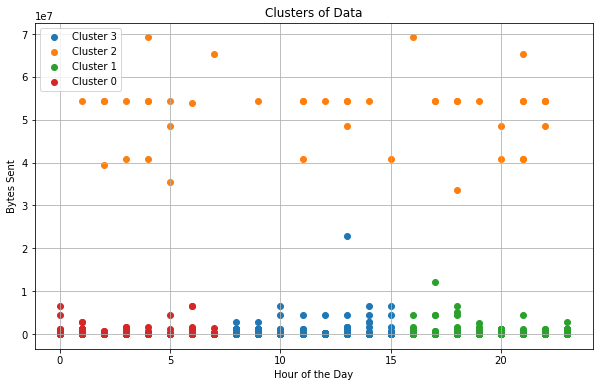

In [74]:
df['hour'] = df['timestamp'].dt.hour

X = df[['hour', 'bytes_sent']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4)
df['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
for cluster_label in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster_label]
    plt.scatter(cluster_data['hour'], cluster_data['bytes_sent'], label=f'Cluster {cluster_label}')
plt.xlabel('Hour of the Day')
plt.ylabel('Bytes Sent')
plt.title('Clusters of Data')
plt.legend()
plt.grid(True)
plt.show()